Statistical physicists use the Ising model as a model for magnetism. They want to know how magnetic materials behave at certain temperatures. The model consists of a lattice, where each site on the lattice has positive or negative spin (represented by a +1 or -1). The lattice behaves according to a probability distribution, and we would like to sample the equilibrium distribution of lattice configurations at a given temperature. However, even for a small number of lattice sites, any function of the distribution over lattice configurations is combinatorially intractable. There are too many configurations of the lattice to sum over. So, to answer questions such as what is the average magnetism (sum of +1s and -1s on the lattice) for the equilibrium distribution at a given temperature, we must sample the configurations with MCMC methods. As usual, for a given iteration of the algorithm, we propose a new configuration by flipping one of the spins uniformly at random. The new configuration is either accepted or rejected according to the normal rules of the Metropolis-Hastings algorithm. We code an algorithm to sample the state space of configurations at a given temperature, and use that sample to compute several quantities of interest below. 

In [1]:
# Import packages

import numpy as np
import random
import matplotlib.pyplot as plt
from array2gif import write_gif
from tqdm import tqdm

In [2]:
# Create initial lattice to start

def create_random_lattice(rows, cols, prob = .5):

    n_trials = 1
    lattice = np.random.binomial(n_trials, prob, [rows, cols])
    lattice_idxs = np.where(lattice == 0)
    lattice[lattice_idxs] = -1

    return lattice

# Compute the probability (up to a normalizing constant) of the configuration

def compute_hamiltonian(lattice):

    num_rows = np.shape(lattice)[0]
    num_cols = np.shape(lattice)[1]
    hamiltonian = 0

    for ii_row in range(np.shape(lattice)[0]):

        for jj_col in range(np.shape(lattice)[1]):

            # Only count neighbors down and to the right to avoid double counting 
            # Periodic boundary conditions
            current_spin = lattice[ii_row, jj_col]
            hamiltonian += current_spin * (lattice[(ii_row + 1) % num_rows, jj_col] + lattice[ii_row, (jj_col + 1) % num_cols])

    return -hamiltonian

def compute_unnormalized_prob(lattice, J_over_kT):

    return np.exp(-J_over_kT * compute_hamiltonian(lattice))

def propose_lattice(lattice):

    num_rows = np.shape(lattice)[0]
    num_cols = np.shape(lattice)[1]
    rnd_row = random.sample(list(range(num_rows)), 1)
    rnd_col = random.sample(list(range(num_cols)), 1)
    new_lattice = np.copy(lattice)
    new_lattice[rnd_row, rnd_col] = -1 * new_lattice[rnd_row, rnd_col] 

    return new_lattice

def metropolis_sampling(lattice, num_iterations, J_over_kT):

    u = np.random.uniform(0, 1, num_iterations)

    with tqdm(total = num_iterations) as pbar:

        sample = np.zeros([np.shape(lattice)[0], np.shape(lattice)[1], num_iterations])

        for ii_iteration in range(num_iterations):
            
            candidate_lattice = propose_lattice(lattice)
            acceptance_prob = np.min([1, np.exp(-J_over_kT * (compute_hamiltonian(candidate_lattice) \
                                                         - compute_hamiltonian(lattice)))])

            if u[ii_iteration] < acceptance_prob:

                lattice = candidate_lattice

            sample[:, :, ii_iteration] = lattice
            pbar.update(1)
    
    return sample

# Write function that creates gif from the sample

def create_image(lattice):

    num_rows = np.shape(lattice)[0]
    num_cols = np.shape(lattice)[1]
    # Turn lattice into image with RGB triplet along third dimension
    image = np.zeros([num_rows, num_cols, 3])
    image[lattice == 1] = [0, 0, 0]
    image[lattice == -1] = [255, 255, 255]

    return image

# Create specific heat function and plot as function of temperature

def compute_specific_heat(samples):

    specific_heat = [np.var(samples[key]) / (float(key) ** 2) for key in samples.keys()]

    return specific_heat

# Create magnetism function that calculates magnetism as function of temperature

def compute_magnetism(samples):

    magnetism = [np.mean(np.ravel(samples[key])) for key in samples.keys()]

    return magnetism
        


We sample the equilibrium distribution for the Ising model at a low temperature. You can watch the lattice configuration evolve over time in the .gif file in this folder. At cooler temperatures, the lattice shows some structure. Similar spins are clustered together. At higher temperatures, the model becomes less structured, and the spins are more random. 

In [3]:
num_rows = 100
num_cols = 100
initial_lattice = create_random_lattice(num_rows, num_cols)
num_iterations = 50000
J_over_kT = 10
print('Metropolis sampling')
sample = metropolis_sampling(initial_lattice, num_iterations, J_over_kT)

# Make sure gif happens fast enough

frequency = 200
dataset_for_gif = []

for ii_lattice in range(int(num_iterations / frequency)):

    dataset_for_gif.append(np.array(create_image(sample[:, :, ii_lattice * frequency])))

print('Writing samples to gif')
write_gif(dataset_for_gif, 'ising_model.gif', fps = 5000)


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 2/50000 [00:00<49:19, 16.90it/s]

Metropolis sampling


100%|██████████| 50000/50000 [17:45<00:00, 46.93it/s]


Writing samples to gif


We calculate the specific heat and total magnetism of the Ising model for a lattice of size 20 x 20 at different temperatures below. 

  1%|          | 58/10000 [00:00<00:17, 572.61it/s]

Metropolis sampling temp:  0


  1%|          | 87/10000 [00:00<00:11, 864.71it/s]

Metropolis sampling temp:  3


  1%|          | 112/10000 [00:00<00:08, 1113.03it/s]

Metropolis sampling temp:  6


  1%|          | 94/10000 [00:00<00:10, 937.37it/s]

Metropolis sampling temp:  9


  0%|          | 37/10000 [00:00<00:34, 291.72it/s]

Metropolis sampling temp:  12


  1%|          | 91/10000 [00:00<00:10, 900.94it/s]

Metropolis sampling temp:  15


  1%|          | 93/10000 [00:00<00:10, 928.38it/s]

Metropolis sampling temp:  18


100%|██████████| 10000/10000 [00:10<00:00, 995.97it/s]
<ipython-input-2-95628867df54>:86: RuntimeWarning: divide by zero encountered in double_scalars
  specific_heat = [np.var(samples[key]) / (float(key) ** 2) for key in samples.keys()]


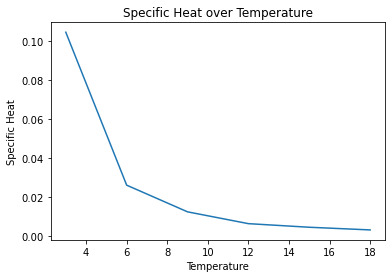

In [5]:
# Calculating specific heat as a function of temperature

num_rows = 20
num_cols = 20
num_iterations = 10000
J_over_kT = np.arange(0, 20, 3)
samples = {}

for ii_temp in J_over_kT:

    print('Metropolis sampling temp: ', ii_temp)
    initial_lattice = create_random_lattice(num_rows, num_cols)
    samples[str(ii_temp)] = metropolis_sampling(initial_lattice, num_iterations, ii_temp)

    # Plot specific heat as function of temperature 

specific_heat = compute_specific_heat(samples)
plt.plot(J_over_kT, specific_heat)
plt.title('Specific Heat over Temperature')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat')
plt.show()

You can see the specific heat decreases as a function of temperature, but total magnetism (sum of +1s and -1s on the lattice) stays constant over temperature. 

  0%|          | 42/50000 [00:00<02:02, 409.32it/s]

Metropolis sampling temp:  0


  0%|          | 116/50000 [00:00<00:43, 1156.87it/s]

Metropolis sampling temp:  3


  0%|          | 121/50000 [00:00<00:41, 1206.19it/s]

Metropolis sampling temp:  6


  0%|          | 119/50000 [00:00<00:41, 1188.70it/s]

Metropolis sampling temp:  9


  0%|          | 122/50000 [00:00<00:41, 1214.50it/s]

Metropolis sampling temp:  12


  0%|          | 115/50000 [00:00<00:43, 1145.08it/s]

Metropolis sampling temp:  15


  0%|          | 125/50000 [00:00<00:40, 1241.70it/s]

Metropolis sampling temp:  18


100%|██████████| 50000/50000 [00:42<00:00, 1181.51it/s]


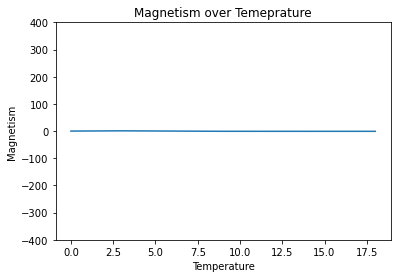

In [8]:
num_rows = 20
num_cols = 20
num_iterations = 50000
J_over_kT = np.arange(0, 20, 3)
samples = {}

for ii_temp in J_over_kT:

    print('Metropolis sampling temp: ', ii_temp)
    initial_lattice = create_random_lattice(num_rows, num_cols)
    samples[str(ii_temp)] = metropolis_sampling(initial_lattice, num_iterations, ii_temp)

magnetism = compute_magnetism(samples)
plt.plot(J_over_kT, magnetism)
plt.xlabel('Temperature')
plt.ylabel('Magnetism')
plt.title('Magnetism over Temeprature')
plt.ylim((-(num_cols ** 2), num_cols ** 2))
plt.show()